In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import SplineTransformer
plt.rcParams.update({'figure.autolayout':True, 'axes.grid':True, 'axes.axisbelow':True, 'grid.color':'0.8', 'grid.linewidth':0.5})

# Conditional Expection and Least Square Regression

Let $X$ and $Y$ be two random variables. The conditional expectation $\mathbb{E}\left[Y|X\right]$ is a function $f^{\ast}$ of $X$ that best approximates $Y$ in the least square sense, i.e.,

$$\mathbb{E}\left[Y|X\right]=f^{\ast}(X)\quad\text{and}\quad\mathbb{E}\left[\left|Y-f^{\ast}(X)\right|^2\right]\leq\mathbb{E}\left[\left|Y-f(X)\right|^2\right]\text{ for any function }f\text{ of }X$$

Let us define the random variables $X$ and $Y$ by
$$
g(x) = x \frac{1 + x}{1 + x^2}, \qquad X \sim \mathcal{N}(0, 1), \quad Y = g(X) + \varepsilon
$$
where $\varepsilon \sim \mathcal{N}(0, 1/16)$ is independent of $X$.

Note that $\mathbb{E}\left[\left.Y\right|X\right] = \mathbb{E}\left[\left.g(X)+\varepsilon\right|X\right] = g(X)+\mathbb{E}\left[\left.\varepsilon\right|X\right] = g(X)$.

Text(0, 0.5, 'Y')

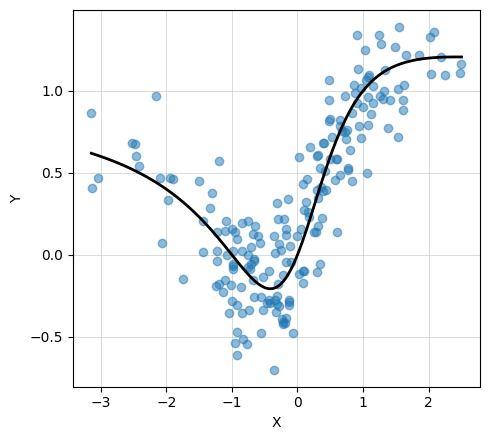

In [2]:
# Plot a random sample of the joint distribution and the
# theoretical conditional expectation of Y wrt X.

def g(x):
    return x*(1+x)/(1+x**2)

n = 200
sigma = 0.25
X = np.random.randn(n)
Y = g(X) + sigma * np.random.randn(n)

fig, ax = plt.subplots(figsize=(5, 4.5))
ax.scatter(X, Y, alpha=0.5)
x = np.linspace(X.min(), X.max(), 101)
ax.plot(x, g(x), 'k', linewidth=2)
ax.set_xlabel('X')
ax.set_ylabel('Y')

## Parametric regression

The conditional expection $\mathbb{E}\left[\left.Y\right|X\right]$ is approximated by a linear combination of a set of given <em>basis</em> functions $\{f_i(X)\}_{0\leq i\leq n}$, i.e.,

$$\mathbb{E}\left[Y|X\right]\approx \beta_0^*f_0(X)+\cdots+\beta_n^*f_n(X)$$

where

$$\mathbb{E}\left[\left(Y-\beta_0^*f_0(X)-\cdots-\beta_n^*f_n(X)\right)^2\right] = \min_{\beta_1,\ldots,\beta_n}\mathbb{E}\left[\left(Y-\beta_0f_0(X)-\cdots-\beta_nf_n(X)\right)^2\right]$$

Given $N$ observations $\left((x_1,y_1),\ldots,(x_N, y_N)\right)$ of $X$ and $Y$, one finds the optimal parameters $\beta_i$ by solving the least square problem $\min_\beta\|A\beta-y\|_2$, where

$$A=\begin{bmatrix}f_0(x_1) & \cdots & f_n(x_1)\\ \vdots & \ddots & \vdots \\ f_0(x_N) & \cdots & f_n(x_N)\end{bmatrix}\quad
\text{and}\quad y=\begin{bmatrix}y_1\\ \vdots \\ y_N\end{bmatrix}$$

The numpy routine <strong>numpy.linalg.lstsq</strong> can be used to solve such linear least square problems.

### Polynomials

The basis functions are taken to be power functions $f_i(X)=X^{i}$, that is $\mathbb{E}\left[Y|X\right]$ is a polynomial of $X$. The numpy routine <strong>numpy.polyfit</strong> is a convenient way to obtain the least square polynomial fit.

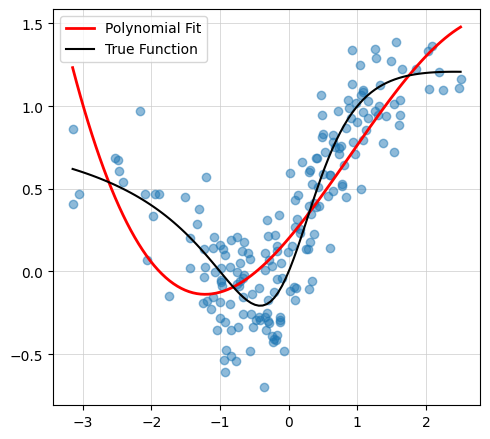

In [3]:
# Fit a polynomial of degree 3 to the sample points (X, Y)
p = np.polyfit(X, Y, deg=3)
fig, ax = plt.subplots(figsize=(5, 4.5))
ax.scatter(X, Y, alpha=0.5)
ax.plot(x, np.polyval(p, x), 'r', lw=2, label='Polynomial Fit')
ax.plot(x, g(x), 'k', label='True Function')
ax.legend(loc=0)

### Piecewise Linear Regression

In [4]:
def pwlin_basis(xknots):
    """Basis that represent a piecewise linear function with given knots"""
    fs = [lambda x: np.ones_like(x, dtype=float), lambda x: x-xknots[0]]
    fs.extend([lambda x, a=xknots[i]: np.maximum(x-a, 0) for i in range(len(xknots))])
    return fs

def pwlin_fit(xdata, ydata, xknots):
    """Fit a piecewise linear function with xknots to xdata and ydata"""
    fs = pwlin_basis(xknots)
    A = np.column_stack([f(xdata) for f in fs])
    ps = np.linalg.lstsq(A, ydata, rcond=None)[0]
    return ps, fs

Text(0, 0.5, 'Y')

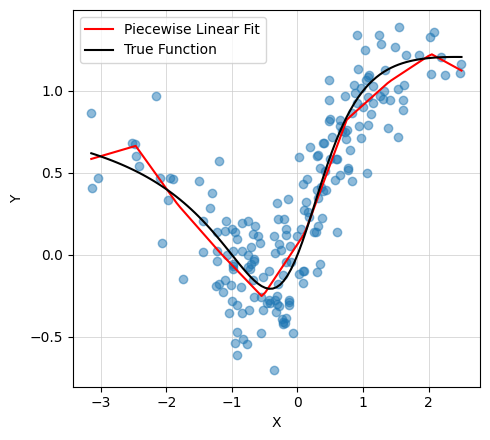

In [5]:
xknots = np.linspace(np.percentile(X, 2.5), np.percentile(X, 97.5), 8)
ps, fs = pwlin_fit(X, Y, xknots)
fig, ax = plt.subplots(figsize=(5, 4.5))
ax.scatter(X, Y, alpha=0.5)
ax.plot(x, sum([f(x)*p for (f, p) in zip(fs, ps)]), 'r', label='Piecewise Linear Fit')
ax.plot(x, g(x), 'k', label='True Function')
ax.legend(loc=0)
ax.set_xlabel('X')
ax.set_ylabel('Y')

## Nonparametric regression

### Nadaraya-Watson Kernel regression (Local Weighted Average)

Here, no parametric form is assumed for $\mathbb{E}[Y|X]$. Instead, local averages of $Y$ values are computed, given the value of $X$:

$$\mathbb{E}\left[Y|X\right]\approx\frac{\sum_{i=1}^NK_h(x-x_i)y_i}{\sum_{i=1}^NK_h(x-x_i)}$$
where $K$ is a kernel function and $K_h(x)=K(x/h)/h$, $h$ is the <em>bandwidth</em>. $K_h$ approximates the Dirac mass at zero.

### Local Linear Regression

The locally weighted linear regression solves a separate weighted least squares problem at each target point $x$,

$$\hat{\alpha},\hat{\beta} = \text{argmin}_{\alpha,\beta}\sum_{i=1}^NK_h(x-x_i)\left[y_i-\alpha-\beta x_i\right]^2$$

which yields an estimate $\hat{\alpha}+\hat{\beta}x$. Note that $\hat{\alpha}$ and $\hat{\beta}$ depend on $x$. The locally-weighted averages can be badly biased on the boundaries. This bias
can be removed by local linear regression to the first order.

<b>Note.</b> To speed up, we often perform the local regression only at a selection of points and then use interpolation/extrapolation to evaluate at other target points.

In [6]:
# Non-parametric regression function

def gauss_kern(x):
    """Gaussian kernel function"""
    return np.exp(-x**2/2)

def kern_reg(x, xdata, ydata, bandwidth, kern=gauss_kern):
    """Nadaraya-Watson Kernel Regression (Locally weighted average)

    Parameters
    ----------
    x: array_like, one-dimensional
        The x-coordinates of the target points
    xdata: array_like
        The x-coordinates of the data points.
    ydata: array_like
        The y-coordinates of the data points.
    bandwidth: positive scalar
        Bandwidth of the kernel
    kern: callable
        kernel function
    """
    weights = kern((xdata[:, np.newaxis] - x) / bandwidth)
    return np.sum(weights * ydata[:, np.newaxis], axis=0) / np.sum(weights, axis=0)


def ll_reg(x, xdata, ydata, bandwidth, kern=gauss_kern):
    """Local Linear Regression

    Parameters
    ----------
    x: array_like, one-dimensional
        The x-coordinates of the target points
    xdata: array_like
        The x-coordinates of the data points.
    ydata: array_like
        The y-coordinates of the data points.
    bandwidth: positive scalar
        Bandwidth of the kernel
    kern: callable
        kernel function
    """

    def func(xx):
        weights = np.sqrt(kern((xdata-xx)/bandwidth))
        b = ydata*weights
        A = np.column_stack((np.ones_like(xdata), xdata-xx))*weights[:, np.newaxis]
        yy, _ = np.linalg.lstsq(A, b, rcond=None)[0]
        return yy

    return np.vectorize(func)(x)

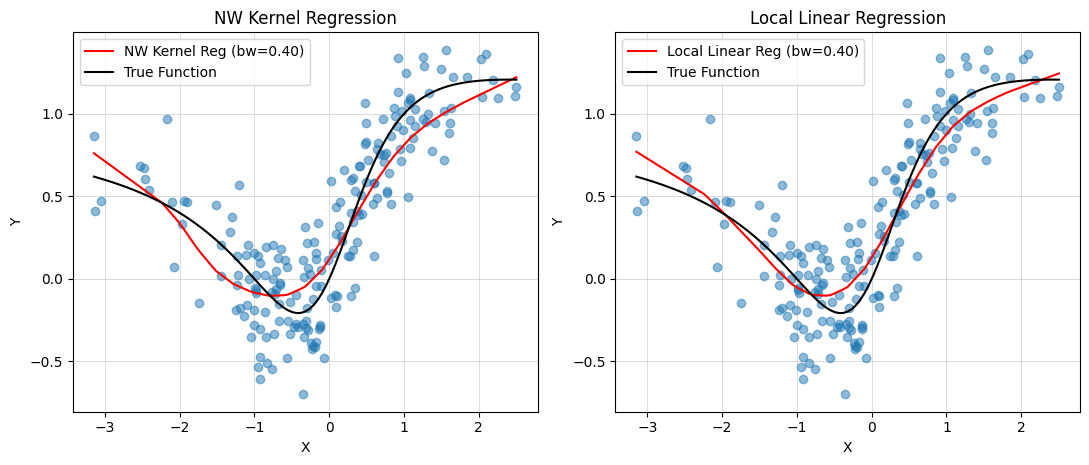

In [7]:
fig, axs = plt.subplots(1,2, figsize=(11, 4.75))
bw_silverman = (4/(3*len(X)))**0.2*np.std(X)
# NW Kernel Regression
xknots0 = np.linspace(np.percentile(X, 2.5), np.percentile(X, 97.5), 20)
yknots0 = kern_reg(xknots0, X, Y, bw_silverman, gauss_kern)
f0 = interp1d(xknots0, yknots0, kind='linear', fill_value='extrapolate')
axs[0].plot(x, f0(x), color='r', label='NW Kernel Reg (bw={:.2f})'.format(bw_silverman))
axs[0].set_title('NW Kernel Regression')
# Local Linear Regression
xknots1 = xknots0
yknots1 = ll_reg(xknots1, X, Y, bw_silverman, gauss_kern)
f1 = interp1d(xknots1, yknots1, kind='linear', fill_value='extrapolate')
axs[1].plot(x, f1(x), color='r', label='Local Linear Reg (bw={:.2f})'.format(bw_silverman))
axs[1].set_title('Local Linear Regression')
for ax in axs:
    ax.scatter(X, Y, alpha=0.5)
    ax.plot(x, g(x), 'k', label='True Function')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend(loc=0)

# Regression Flexibility and Overfitting: Parametric vs Nonparametric

In this notebook you will explore how model flexibility affects fit quality.  You will:

- Fit **polynomial regressions** of varying degree.  
- Fit **piecewise‐linear regressions** with different numbers of knots.  
- Fit **kernel regressions** (Nadaraya–Watson) with different bandwidths and kernels.  
- Reproduce scatter‐plus‐fit plots and compare underfit/overfit behavior.

---

## 1. Parametric Regression

### 1.1 Polynomial Regression

Fit polynomials of different degree e.g. `degrees = [1, 3, 5, 7, 9]`:

> **Compare**  
> - Which degrees underfit?  
> - Which degrees overfit the noise?  
> - How does test‐set error behave as you increase \(d\)?

### 1.2 Piecewise‐Linear

Use different values for the knots e.g. `n_knots = [3, 5, 10]`:

> **Compare**  
> - How does the fit change as you add more knots?  
> - At what point does it start “wiggling” too much?

---

## 2. Nonparametric Kernel Regression

We implement the Nadaraya–Watson estimator with various kernels.

> **Compare**  
> - What kernels are usually used and which ones perform the best?
> - Is this a better method than parametric regression? In what way?

In [8]:
n_simulations = 100

X_train_list = [np.random.randn(200) for _ in range(n_simulations)]
Y_train_list = [g(X) + sigma * np.random.randn(200) for X in X_train_list]
X_test_list = [np.random.randn(200) for _ in range(n_simulations)]
Y_test_list = [g(X) + sigma * np.random.randn(200) for X in X_test_list]

# 1. Parametric Regression

## 1.1 Polynomial Regression

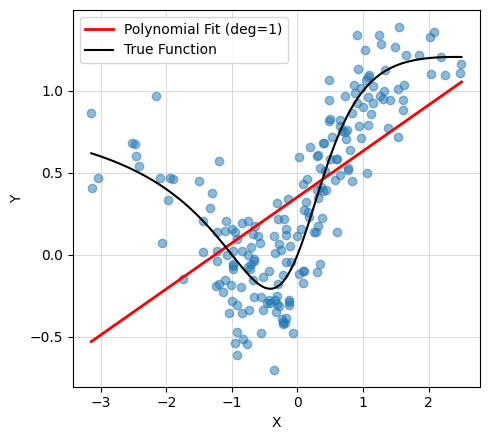

In [9]:
# degree = 1

p1 = np.polyfit(X, Y, deg=1)
fig, ax = plt.subplots(figsize=(5, 4.5))
ax.scatter(X, Y, alpha=0.5)
ax.plot(x, np.polyval(p1, x), 'r', lw=2, label='Polynomial Fit (deg=1)')
ax.plot(x, g(x), 'k', label='True Function')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend(loc=0)

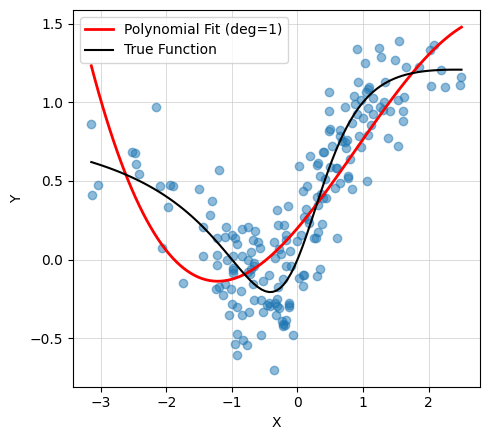

In [10]:
# degree = 3

p3 = np.polyfit(X, Y, deg=3)
fig, ax = plt.subplots(figsize=(5, 4.5))
ax.scatter(X, Y, alpha=0.5)
ax.plot(x, np.polyval(p3, x), 'r', lw=2, label='Polynomial Fit (deg=1)')
ax.plot(x, g(x), 'k', label='True Function')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend(loc=0)

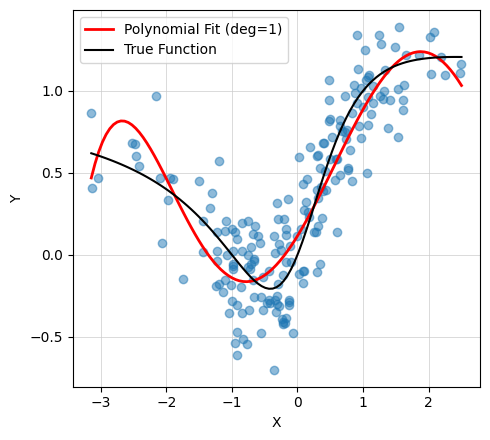

In [11]:
# degree = 5

p5 = np.polyfit(X, Y, deg=5)
fig, ax = plt.subplots(figsize=(5, 4.5))
ax.scatter(X, Y, alpha=0.5)
ax.plot(x, np.polyval(p5, x), 'r', lw=2, label='Polynomial Fit (deg=1)')
ax.plot(x, g(x), 'k', label='True Function')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend(loc=0)

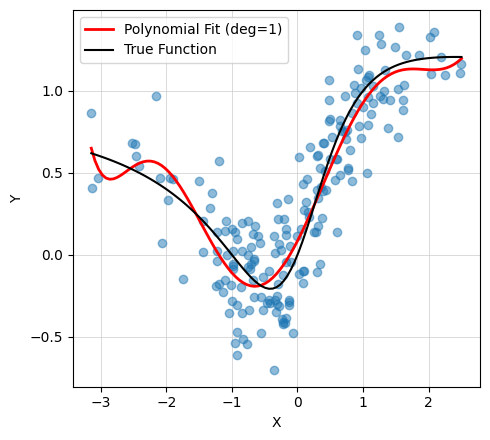

In [12]:
# degree = 7

p7 = np.polyfit(X, Y, deg=7)
fig, ax = plt.subplots(figsize=(5, 4.5))
ax.scatter(X, Y, alpha=0.5)
ax.plot(x, np.polyval(p7, x), 'r', lw=2, label='Polynomial Fit (deg=1)')
ax.plot(x, g(x), 'k', label='True Function')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend(loc=0)

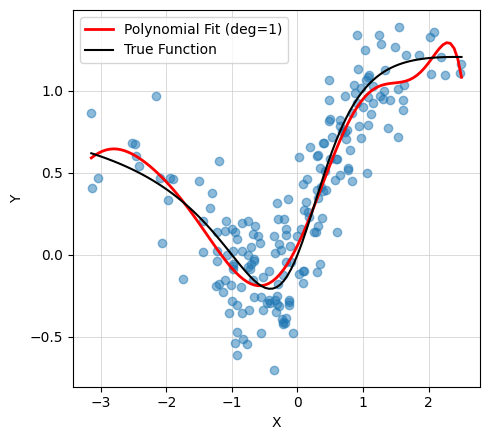

In [13]:
# degree = 9

p9 = np.polyfit(X, Y, deg=9)
fig, ax = plt.subplots(figsize=(5, 4.5))
ax.scatter(X, Y, alpha=0.5)
ax.plot(x, np.polyval(p9, x), 'r', lw=2, label='Polynomial Fit (deg=1)')
ax.plot(x, g(x), 'k', label='True Function')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend(loc=0)

In [14]:
# simulation
degrees = [1, 3, 5, 7, 9]

poly_train_errors = {deg: [] for deg in degrees}
poly_test_errors = {deg: [] for deg in degrees}

for i in range(n_simulations):
    X_train = X_train_list[i]
    Y_train = Y_train_list[i]

    X_test = X_test_list[i]
    Y_test = Y_test_list[i]

    for deg in degrees:
        p = np.polyfit(X_train, Y_train, deg=deg)

        Y_pred_train = np.polyval(p, X_train)
        train_mse = np.mean((Y_train - Y_pred_train)**2)
        poly_train_errors[deg].append(train_mse)

        Y_pred_test = np.polyval(p, X_test)
        test_mse = np.mean((Y_test - Y_pred_test)**2)
        poly_test_errors[deg].append(test_mse)

In [15]:
# Table
poly_results = []
for deg in degrees:
    train_mean = np.mean(poly_train_errors[deg])
    train_std = np.std(poly_train_errors[deg])
    test_mean = np.mean(poly_test_errors[deg])
    test_std = np.std(poly_test_errors[deg])
    gap = test_mean - train_mean

    poly_results.append({
        'Degree': deg,
        'Train MSE (mean)': train_mean,
        'Train MSE (std)': train_std,
        'Test MSE (mean)': test_mean,
        'Test MSE (std)': test_std,
        'Train-Test Gap': gap
    })

df_poly = pd.DataFrame(poly_results)
print(df_poly.to_string(index=False))

 Degree  Train MSE (mean)  Train MSE (std)  Test MSE (mean)  Test MSE (std)  Train-Test Gap
      1          0.166845         0.016974         0.167077        0.016953        0.000232
      3          0.091342         0.011977         0.097562        0.016614        0.006220
      5          0.066916         0.007827         0.099125        0.085597        0.032209
      7          0.060705         0.006849         0.231858        0.603128        0.171153
      9          0.058530         0.006506         5.722390       39.631440        5.663860


In [16]:
# Statistical analysis

print("="*80)
print("POLYNOMIAL REGRESSION ANALYSIS")
print("="*80)

irreducible_err = sigma**2
acceptable_mse = irreducible_err * 3
overfit_gap = 0.5
underfit_gap = 0.3

print(f"\nCriteria:")
print(f"  Irreducible error: {irreducible_err:.4f}")
print(f"  Acceptable test MSE: < {acceptable_mse:.4f}")
print(f"  Overfit: Gap/Train > {overfit_gap*100:.0f}%")
print(f"  Underfit: Test MSE > {acceptable_mse:.4f} AND Gap/Train < {underfit_gap*100:.0f}%")

poly_classifications = {}
for idx, row in df_poly.iterrows():
    d = int(row['Degree'])
    test_mse = row['Test MSE (mean)']
    train_mse = row['Train MSE (mean)']
    gap = row['Train-Test Gap']
    gap_ratio = gap / train_mse

    if gap_ratio > overfit_gap:
        poly_classifications[d] = "overfit"
    elif test_mse > acceptable_mse:
        poly_classifications[d] = "underfit" if gap_ratio < underfit_gap else "poor"
    else:
        poly_classifications[d] = "acceptable"

print("\n" + "="*80)
print("[Q1] Which degrees underfit?")
print("="*80)

underfit_degs = [d for d, c in poly_classifications.items() if c == "underfit"]

if underfit_degs:
    print(f"\nUnderfit degrees: {underfit_degs}")
    for d in underfit_degs:
        row = df_poly[df_poly['Degree'] == d].iloc[0]
        gap_ratio = row['Train-Test Gap'] / row['Train MSE (mean)']
        print(f"  d={d}: test={row['Test MSE (mean)']:.4f}, gap/train={gap_ratio*100:.1f}%")
else:
    print(f"\nNone")

print("\n" + "="*80)
print("[Q2] Which degrees overfit the noise?")
print("="*80)

overfit_degs = [d for d, c in poly_classifications.items() if c == "overfit"]

if overfit_degs:
    print(f"\nOverfit degrees: {overfit_degs}")
    for d in overfit_degs:
        row = df_poly[df_poly['Degree'] == d].iloc[0]
        gap_ratio = row['Train-Test Gap'] / row['Train MSE (mean)']
        print(f"  d={d}: train={row['Train MSE (mean)']:.4f}, test={row['Test MSE (mean)']:.4f}, gap/train={gap_ratio*100:.1f}%")
else:
    print(f"\nNone")

print("\n" + "="*80)
print("[Q3] How does test-set error behave as you increase d?")
print("="*80)

print("\nTest MSE progression:")
df_sorted = df_poly.sort_values('Degree')
prev_mse = None
for idx, row in df_sorted.iterrows():
    d = int(row['Degree'])
    test_mse = row['Test MSE (mean)']

    if prev_mse is None:
        change = ""
    else:
        diff = test_mse - prev_mse
        change = f"  ({'+' if diff > 0 else ''}{diff:.4f})"

    print(f"  d={d}: {test_mse:.4f}{change}")
    prev_mse = test_mse

print("="*80)

POLYNOMIAL REGRESSION ANALYSIS

Criteria:
  Irreducible error: 0.0625
  Acceptable test MSE: < 0.1875
  Overfit: Gap/Train > 50%
  Underfit: Test MSE > 0.1875 AND Gap/Train < 30%

[Q1] Which degrees underfit?

None

[Q2] Which degrees overfit the noise?

Overfit degrees: [7, 9]
  d=7: train=0.0607, test=0.2319, gap/train=281.9%
  d=9: train=0.0585, test=5.7224, gap/train=9676.9%

[Q3] How does test-set error behave as you increase d?

Test MSE progression:
  d=1: 0.1671
  d=3: 0.0976  (-0.0695)
  d=5: 0.0991  (+0.0016)
  d=7: 0.2319  (+0.1327)
  d=9: 5.7224  (+5.4905)


## 1.2 Piecewise-Linear

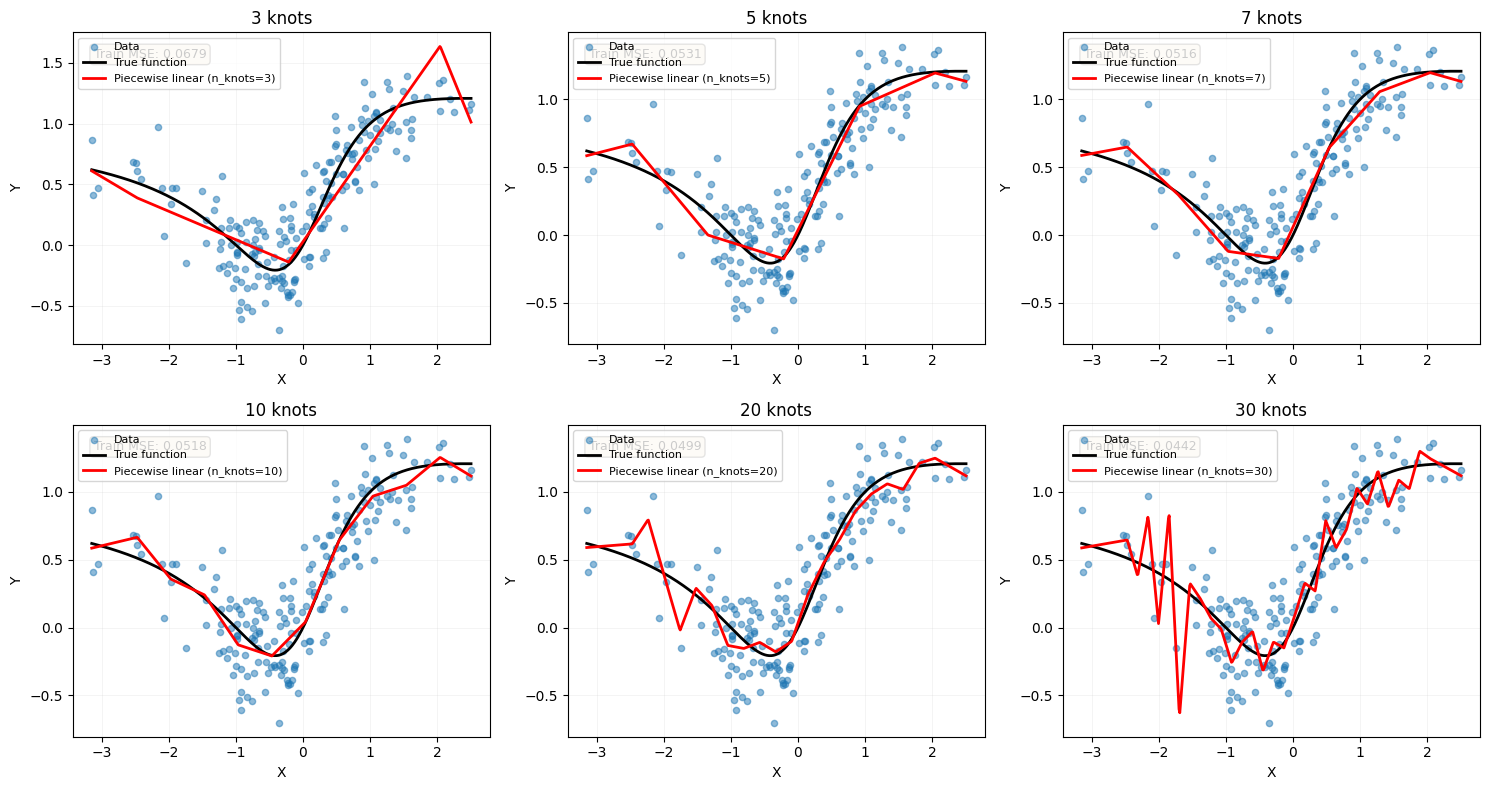

In [17]:
# Visualization

n_knots_list = [3, 5, 7, 10, 20, 30]
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, n_knots in enumerate(n_knots_list):
    ax = axes[idx]

    xknots = np.linspace(np.percentile(X, 2.5), np.percentile(X, 97.5), n_knots)
    ps, fs = pwlin_fit(X, Y, xknots)

    x_grid = np.linspace(X.min(), X.max(), 500)
    y_pred = sum([f(x_grid)*p for (f, p) in zip(fs, ps)])

    Y_pred_train = sum([f(X)*p for (f, p) in zip(fs, ps)])
    train_mse = np.mean((Y - Y_pred_train)**2)

    ax.scatter(X, Y, alpha=0.5, s=20, label='Data')
    ax.plot(x_grid, g(x_grid), 'k', linewidth=2, label='True function')
    ax.plot(x_grid, y_pred, 'r', linewidth=2, label=f'Piecewise linear (n_knots={n_knots})')

    ax.text(0.05, 0.95, f'Train MSE: {train_mse:.4f}',
            transform=ax.transAxes, fontsize=9,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(f'{n_knots} knots')
    ax.legend(loc='best', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [18]:
# Statistical analysis

print("="*80)
print("PIECEWISE LINEAR REGRESSION ANALYSIS")
print("="*80)

n_knots_list = [3, 5, 7, 10, 20, 30]

piece_train_errors = {n: [] for n in n_knots_list}
piece_test_errors = {n: [] for n in n_knots_list}

for i in range(n_simulations):
    X_train = X_train_list[i]
    Y_train = Y_train_list[i]

    X_test = X_test_list[i]
    Y_test = Y_test_list[i]

    for n_knots in n_knots_list:
        xknots = np.linspace(np.percentile(X_train, 2.5), np.percentile(X_train, 97.5), n_knots)
        ps, fs = pwlin_fit(X_train, Y_train, xknots)

        Y_pred_train = sum([f(X_train)*p for (f, p) in zip(fs, ps)])
        train_mse = np.mean((Y_train - Y_pred_train)**2)
        piece_train_errors[n_knots].append(train_mse)

        Y_pred_test = sum([f(X_test)*p for (f, p) in zip(fs, ps)])
        test_mse = np.mean((Y_test - Y_pred_test)**2)
        piece_test_errors[n_knots].append(test_mse)

piece_results = []
for n_knots in n_knots_list:
    train_mean = np.mean(piece_train_errors[n_knots])
    train_std = np.std(piece_train_errors[n_knots])
    test_mean = np.mean(piece_test_errors[n_knots])
    test_std = np.std(piece_test_errors[n_knots])
    gap = test_mean - train_mean
    gap_ratio = gap / train_mean

    piece_results.append({
        'n_knots': n_knots,
        'Train MSE': train_mean,
        'Train Std': train_std,
        'Test MSE': test_mean,
        'Test Std': test_std,
        'Gap': gap,
        'Gap/Train': gap_ratio
    })

df_piece = pd.DataFrame(piece_results)
print("\n" + df_piece.to_string(index=False))

irreducible_err = sigma**2
acceptable_mse = irreducible_err * 3
overfit_gap = 0.5
underfit_gap = 0.3

print(f"\n" + "="*80)
print("Criteria:")
print(f"  Irreducible error: {irreducible_err:.4f}")
print(f"  Acceptable test MSE: < {acceptable_mse:.4f}")
print(f"  Overfit: Gap/Train > {overfit_gap*100:.0f}%")
print(f"  Underfit: Test MSE > {acceptable_mse:.4f} AND Gap/Train < {underfit_gap*100:.0f}%")

piece_classifications = []
for idx, row in df_piece.iterrows():
    n = int(row['n_knots'])
    test_mse = row['Test MSE']
    train_mse = row['Train MSE']
    gap_ratio = row['Gap/Train']

    if gap_ratio > overfit_gap:
        regime = "overfit"
    elif test_mse > acceptable_mse:
        regime = "underfit" if gap_ratio < underfit_gap else "poor"
    else:
        regime = "acceptable"

    piece_classifications.append({
        'n_knots': n,
        'Train MSE': train_mse,
        'Test MSE': test_mse,
        'Gap/Train': gap_ratio,
        'Regime': regime
    })

df_piece_class = pd.DataFrame(piece_classifications)

print("\n" + "="*80)
print("Classification:")
print("="*80)
print("\n" + df_piece_class.to_string(index=False))

print("="*80)



PIECEWISE LINEAR REGRESSION ANALYSIS

 n_knots  Train MSE  Train Std  Test MSE  Test Std      Gap  Gap/Train
       3   0.085708   0.013793  0.092971  0.028257 0.007263   0.084743
       5   0.063142   0.007308  0.068508  0.007503 0.005366   0.084983
       7   0.059237   0.006325  0.065936  0.007443 0.006699   0.113087
      10   0.057889   0.006331  0.066209  0.007190 0.008320   0.143715
      20   0.054482   0.006444  0.072188  0.009248 0.017706   0.324988
      30   0.051561   0.006013  2.564638 19.706127 2.513077  48.739960

Criteria:
  Irreducible error: 0.0625
  Acceptable test MSE: < 0.1875
  Overfit: Gap/Train > 50%
  Underfit: Test MSE > 0.1875 AND Gap/Train < 30%

Classification:

 n_knots  Train MSE  Test MSE  Gap/Train     Regime
       3   0.085708  0.092971   0.084743 acceptable
       5   0.063142  0.068508   0.084983 acceptable
       7   0.059237  0.065936   0.113087 acceptable
      10   0.057889  0.066209   0.143715 acceptable
      20   0.054482  0.072188   0.32498

In [19]:
# Conclusion

print("\n" + "="*80)
print("[Q1] How does the fit change as you add more knots?")
print("="*80)

print("\nTrain MSE progression:")
prev_train = None
for idx, row in df_piece.iterrows():
    n = int(row['n_knots'])
    train_mse = row['Train MSE']

    if prev_train is None:
        change_str = ""
    else:
        change = train_mse - prev_train
        pct_change = (change / prev_train) * 100
        change_str = f"  (Δ={change:+.4f}, {pct_change:+.1f}%)"

    print(f"  n_knots={n:2d}: Train MSE = {train_mse:.4f}{change_str}")
    prev_train = train_mse

print("\nTest MSE progression:")
prev_test = None
for idx, row in df_piece.iterrows():
    n = int(row['n_knots'])
    test_mse = row['Test MSE']

    if prev_test is None:
        change_str = ""
    else:
        change = test_mse - prev_test
        pct_change = (change / prev_test) * 100
        change_str = f"  (Δ={change:+.4f}, {pct_change:+.1f}%)"

    print(f"  n_knots={n:2d}: Test MSE = {test_mse:.4f}{change_str}")
    prev_test = test_mse

best_test_idx = df_piece['Test MSE'].idxmin()
best_n_knots = int(df_piece.loc[best_test_idx, 'n_knots'])
best_test_mse = df_piece.loc[best_test_idx, 'Test MSE']

print(f"\n→ Train MSE monotonically decreases (higher flexibility)")
print(f"→ Test MSE optimal at n_knots={best_n_knots}: {best_test_mse:.4f}")

print("\n" + "="*80)
print("[Q2] At what point does it start 'wiggling' too much?")
print("="*80)

overfit_configs = df_piece_class[df_piece_class['Regime'] == 'overfit']

if len(overfit_configs) > 0:
    first_overfit_n = int(overfit_configs.iloc[0]['n_knots'])
    first_overfit_gap = overfit_configs.iloc[0]['Gap/Train']
    print(f"\nOverfitting detected at n_knots={first_overfit_n} (Gap/Train={first_overfit_gap*100:.1f}%)")
else:
    print(f"\nNo overfitting detected (all Gap/Train < {overfit_gap*100:.0f}%)")

print("="*80)


[Q1] How does the fit change as you add more knots?

Train MSE progression:
  n_knots= 3: Train MSE = 0.0857
  n_knots= 5: Train MSE = 0.0631  (Δ=-0.0226, -26.3%)
  n_knots= 7: Train MSE = 0.0592  (Δ=-0.0039, -6.2%)
  n_knots=10: Train MSE = 0.0579  (Δ=-0.0013, -2.3%)
  n_knots=20: Train MSE = 0.0545  (Δ=-0.0034, -5.9%)
  n_knots=30: Train MSE = 0.0516  (Δ=-0.0029, -5.4%)

Test MSE progression:
  n_knots= 3: Test MSE = 0.0930
  n_knots= 5: Test MSE = 0.0685  (Δ=-0.0245, -26.3%)
  n_knots= 7: Test MSE = 0.0659  (Δ=-0.0026, -3.8%)
  n_knots=10: Test MSE = 0.0662  (Δ=+0.0003, +0.4%)
  n_knots=20: Test MSE = 0.0722  (Δ=+0.0060, +9.0%)
  n_knots=30: Test MSE = 2.5646  (Δ=+2.4925, +3452.7%)

→ Train MSE monotonically decreases (higher flexibility)
→ Test MSE optimal at n_knots=7: 0.0659

[Q2] At what point does it start 'wiggling' too much?

Overfitting detected at n_knots=30 (Gap/Train=4874.0%)


# 2. Nonparametric Kernel Regression

In [20]:
# Additional kernel functions

def epanechnikov_kern(x):
    """Epanechnikov kernel (theoretically optimal)"""
    return np.where(np.abs(x) <= 1, 0.75 * (1 - x**2), 0)

def uniform_kern(x):
    """Uniform (Rectangular) kernel"""
    return np.where(np.abs(x) <= 1, 0.5, 0)

def triangular_kern(x):
    """Triangular kernel"""
    return np.where(np.abs(x) <= 1, 1 - np.abs(x), 0)

kernels_dict = {
    'Gaussian': gauss_kern,
    'Epanechnikov': epanechnikov_kern,
    'Uniform': uniform_kern,
    'Triangular': triangular_kern
}

bandwidths = [0.1, 0.5, 1.0, 1.5, 2.0]

In [21]:
def plot_kernel_regression(X_data, Y_data, kernel_name, kernel_func, bandwidths_list):

    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()

    for idx, h in enumerate(bandwidths_list):
        ax = axes[idx]

        x_grid = np.linspace(X_data.min(), X_data.max(), 500)
        y_pred = kern_reg(x_grid, X_data, Y_data, h, kernel_func)

        Y_pred_train = kern_reg(X_data, X_data, Y_data, h, kernel_func)
        train_mse = np.mean((Y_data - Y_pred_train)**2)

        ax.scatter(X_data, Y_data, alpha=0.5, s=20, label='Data')
        ax.plot(x_grid, g(x_grid), 'k', linewidth=2, label='True function')
        ax.plot(x_grid, y_pred, 'r', linewidth=2, label=f'{kernel_name} (h={h})')

        ax.text(0.05, 0.95, f'Train MSE: {train_mse:.4f}',
                transform=ax.transAxes, fontsize=9,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_title(f'Bandwidth = {h}')
        ax.legend(loc='best', fontsize=8)
        ax.grid(True, alpha=0.3)

    if len(bandwidths_list) < len(axes):
        axes[-1].axis('off')

    plt.suptitle(f'{kernel_name} Kernel with Different Bandwidths', fontsize=14, y=1.00)
    plt.tight_layout()
    plt.show()

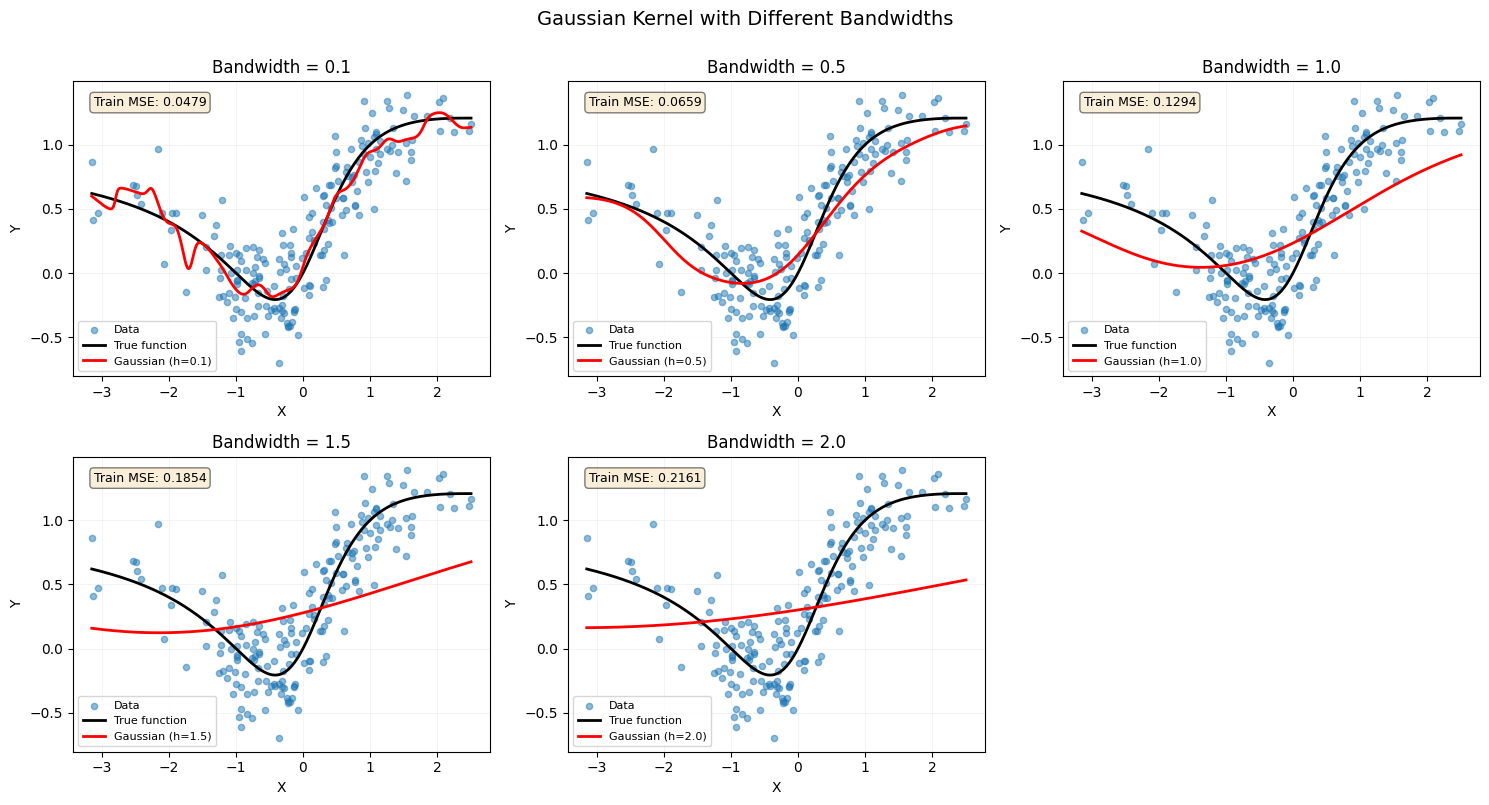

In [22]:
# Gaussian kernel
plot_kernel_regression(X, Y, 'Gaussian', gauss_kern, bandwidths)

/var/folders/gk/nctnx6qn60x0zk9b3wcs62rh0000gn/T/ipykernel_72005/4129240193.py:24: RuntimeWarning: invalid value encountered in divide
  return np.sum(weights * ydata[:, np.newaxis], axis=0) / np.sum(weights, axis=0)


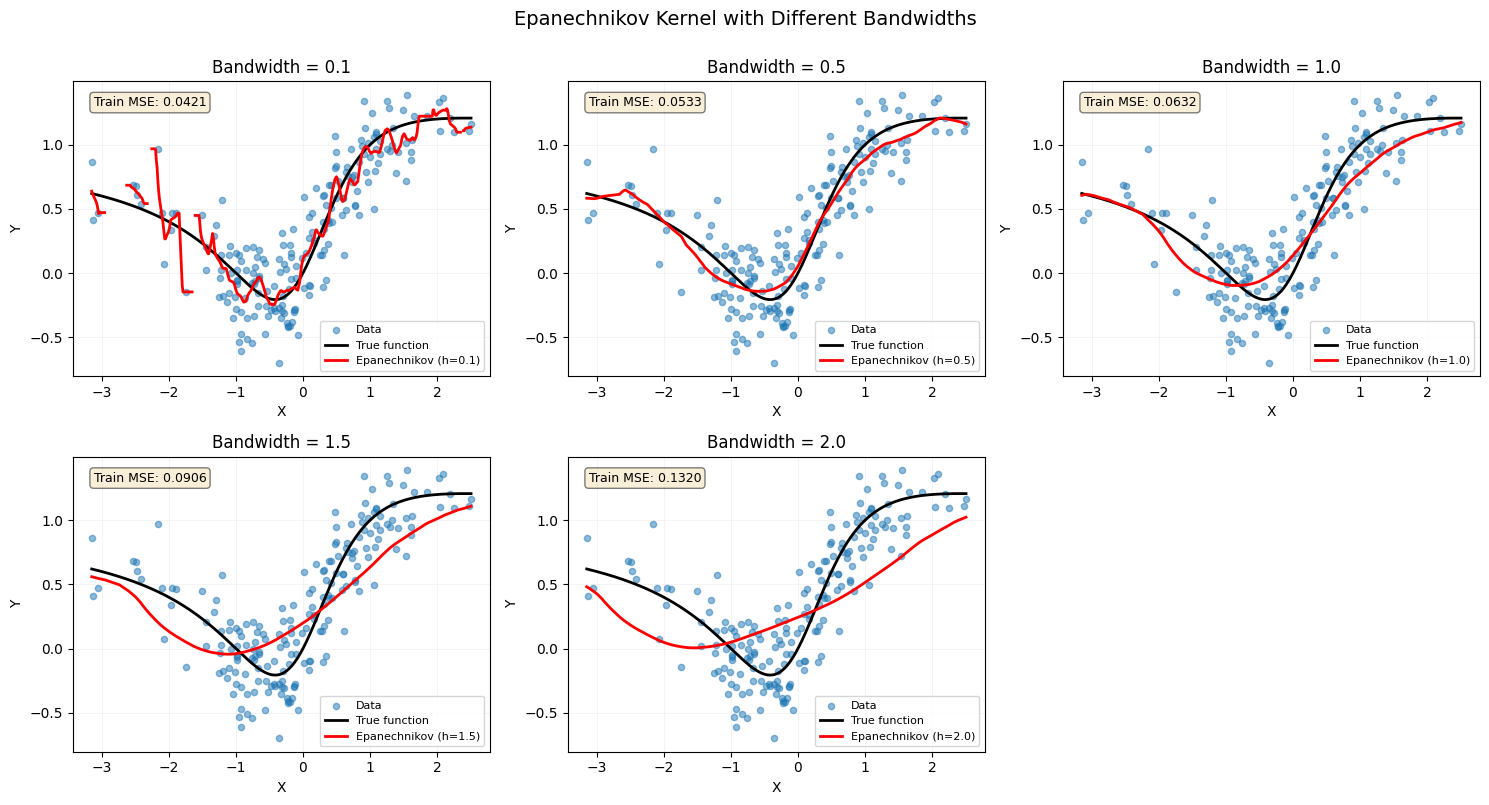

In [23]:
# Epanechnikov kernel
plot_kernel_regression(X, Y, 'Epanechnikov', epanechnikov_kern, bandwidths)

/var/folders/gk/nctnx6qn60x0zk9b3wcs62rh0000gn/T/ipykernel_72005/4129240193.py:24: RuntimeWarning: invalid value encountered in divide
  return np.sum(weights * ydata[:, np.newaxis], axis=0) / np.sum(weights, axis=0)


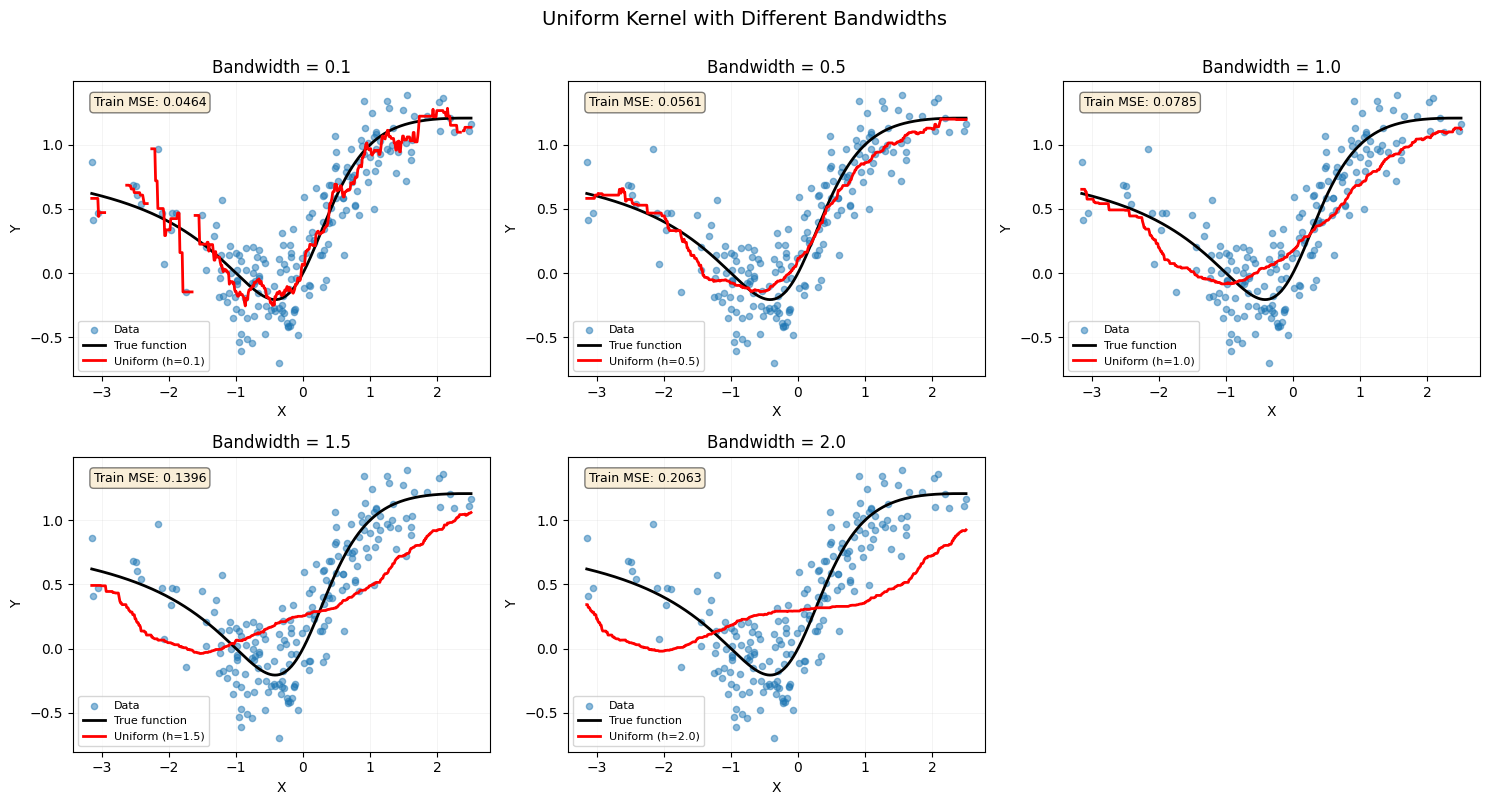

In [24]:
# Uniform kernel
plot_kernel_regression(X, Y, 'Uniform', uniform_kern, bandwidths)

/var/folders/gk/nctnx6qn60x0zk9b3wcs62rh0000gn/T/ipykernel_72005/4129240193.py:24: RuntimeWarning: invalid value encountered in divide
  return np.sum(weights * ydata[:, np.newaxis], axis=0) / np.sum(weights, axis=0)


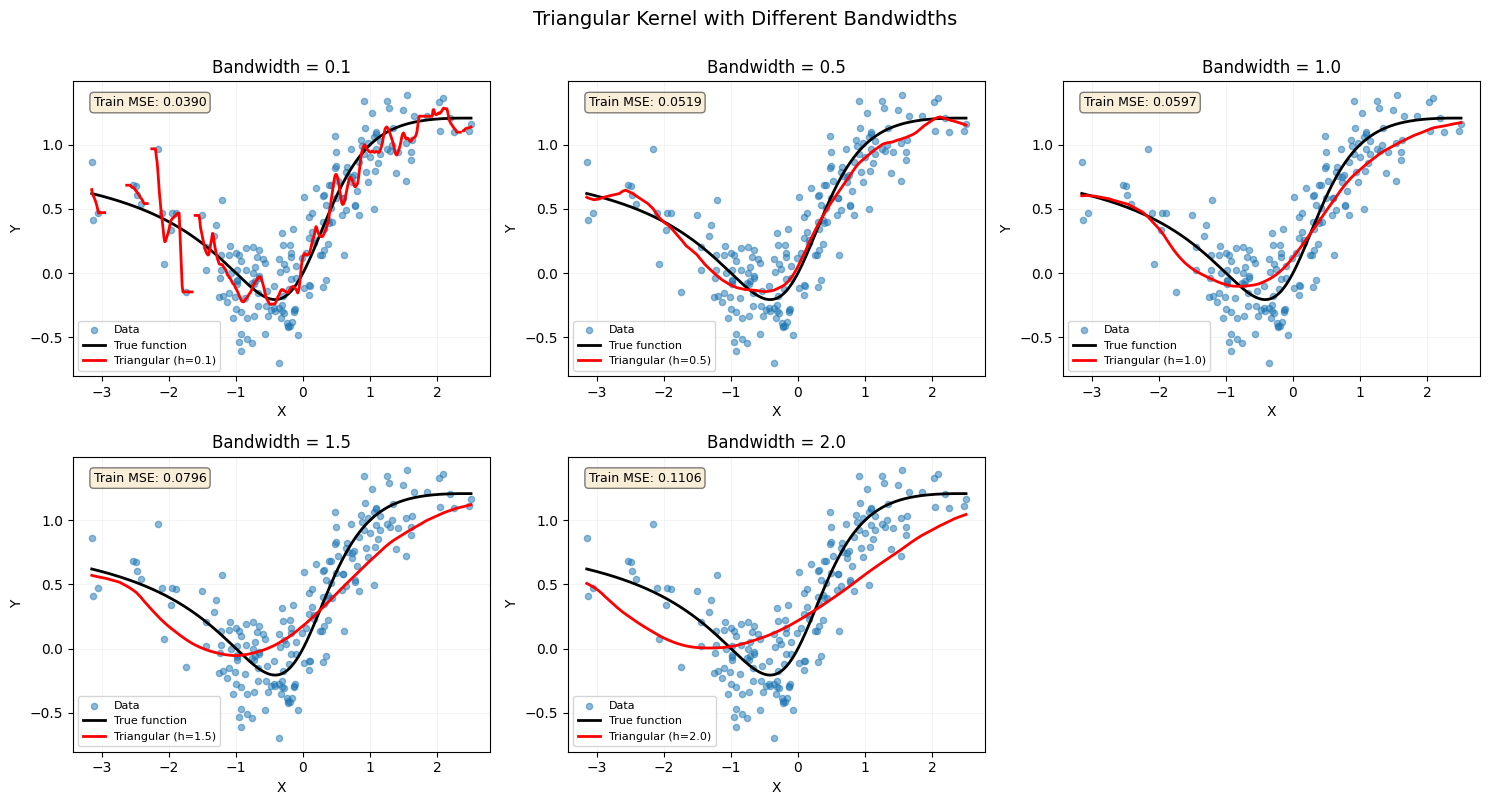

In [25]:
# Triangular kernel
plot_kernel_regression(X, Y, 'Triangular', triangular_kern, bandwidths)

In [26]:
# Statistical analysis

print("="*80)
print("KERNEL REGRESSION ANALYSIS")
print("="*80)

kern_train_errors = {(name, h): [] for name in kernels_dict.keys() for h in bandwidths}
kern_test_errors = {(name, h): [] for name in kernels_dict.keys() for h in bandwidths}

for i in range(n_simulations):
    X_train = X_train_list[i]
    Y_train = Y_train_list[i]

    X_test = X_test_list[i]
    Y_test = Y_test_list[i]

    for kernel_name, kernel_func in kernels_dict.items():
        for h in bandwidths:
            Y_pred_train = kern_reg(X_train, X_train, Y_train, h, kernel_func)
            train_mse = np.mean((Y_train - Y_pred_train)**2)
            kern_train_errors[(kernel_name, h)].append(train_mse)

            Y_pred_test = kern_reg(X_test, X_train, Y_train, h, kernel_func)
            valid_mask = ~np.isnan(Y_pred_test)

            if np.sum(valid_mask) > 0:
                test_mse = np.mean((Y_test[valid_mask] - Y_pred_test[valid_mask])**2)
            else:
                test_mse = np.nan

            kern_test_errors[(kernel_name, h)].append(test_mse)

kern_results = []
for kernel_name in kernels_dict.keys():
    for h in bandwidths:
        key = (kernel_name, h)
        train_mean = np.mean(kern_train_errors[key])
        train_std = np.std(kern_train_errors[key])
        test_mean = np.nanmean(kern_test_errors[key])
        test_std = np.nanstd(kern_test_errors[key])
        gap = test_mean - train_mean
        gap_ratio = gap / train_mean if train_mean > 0 else np.nan

        kern_results.append({
            'Kernel': kernel_name,
            'Bandwidth': h,
            'Train MSE': train_mean,
            'Train Std': train_std,
            'Test MSE': test_mean,
            'Test Std': test_std,
            'Gap': gap,
            'Gap/Train': gap_ratio
        })

df_kern = pd.DataFrame(kern_results)
print("\n" + df_kern.to_string(index=False))

irreducible_err = sigma**2
acceptable_mse = irreducible_err * 3
overfit_gap = 0.5
underfit_gap = 0.3

print(f"\n" + "="*80)
print("Criteria:")
print(f"  Irreducible error: {irreducible_err:.4f}")
print(f"  Acceptable test MSE: < {acceptable_mse:.4f}")
print(f"  Overfit: Gap/Train > {overfit_gap*100:.0f}%")
print(f"  Underfit: Test MSE > {acceptable_mse:.4f} AND Gap/Train < {underfit_gap*100:.0f}%")

kern_classifications = []
for idx, row in df_kern.iterrows():
    kernel_name = row['Kernel']
    h = row['Bandwidth']
    test_mse = row['Test MSE']
    train_mse = row['Train MSE']
    gap_ratio = row['Gap/Train']

    if np.isnan(gap_ratio) or np.isnan(test_mse):
        regime = "insufficient data"
    elif gap_ratio > overfit_gap:
        regime = "overfit"
    elif test_mse > acceptable_mse:
        regime = "underfit" if gap_ratio < underfit_gap else "poor"
    else:
        regime = "acceptable"

    kern_classifications.append({
        'Kernel': kernel_name,
        'Bandwidth': h,
        'Train MSE': train_mse,
        'Test MSE': test_mse,
        'Gap/Train': gap_ratio,
        'Regime': regime
    })

df_kern_class = pd.DataFrame(kern_classifications)

print("\n" + "="*80)
print("Classification:")
print("="*80)
print("\n" + df_kern_class.to_string(index=False))

print("="*80)

print("\n" + "="*80)
print("[Q1] What kernels are usually used and which ones perform the best?")
print("="*80)

acceptable = df_kern_class[df_kern_class['Regime'] == 'acceptable']
kernel_best = acceptable.groupby('Kernel')['Test MSE'].min().sort_values()

print("\nPerformance ranking by kernel:")
for rank, (kernel, mse) in enumerate(kernel_best.items(), 1):
    h_opt = acceptable[(acceptable['Kernel']==kernel) & (acceptable['Test MSE']==mse)]['Bandwidth'].iloc[0]
    print(f"  {rank}. {kernel:12s} (h={h_opt:4.1f}): Test MSE = {mse:.4f}")

print(f"\n→ {kernel_best.index[0]} achieves the best performance (Test MSE = {kernel_best.iloc[0]:.4f})")
print("But, generally Gaussian Kernel is most frequently used")

print("\n" + "="*80)
print("[Q2] Is this a better method than parametric regression? In what way?")
print("="*80)

methods = {
    'Kernel': kernel_best.iloc[0],
    'Piecewise': df_piece['Test MSE'].min(),
    'Polynomial': df_poly['Test MSE (mean)'].min()
}
methods_sorted = sorted(methods.items(), key=lambda x: x[1])

print("\nPerformance comparison:")
for rank, (method, mse) in enumerate(methods_sorted, 1):
    print(f"  {rank}. {method:12s}: Test MSE = {mse:.4f}")

print(f"\n→ {methods_sorted[0][0]} regression achieves the best overall performance")

print("="*80)

/var/folders/gk/nctnx6qn60x0zk9b3wcs62rh0000gn/T/ipykernel_72005/4129240193.py:24: RuntimeWarning: invalid value encountered in divide
  return np.sum(weights * ydata[:, np.newaxis], axis=0) / np.sum(weights, axis=0)


KERNEL REGRESSION ANALYSIS

      Kernel  Bandwidth  Train MSE  Train Std  Test MSE  Test Std       Gap  Gap/Train
    Gaussian        0.1   0.053903   0.006178  0.066975  0.007050  0.013071   0.242495
    Gaussian        0.5   0.080520   0.007345  0.082704  0.009436  0.002184   0.027119
    Gaussian        1.0   0.152240   0.010578  0.152440  0.014310  0.000199   0.001308
    Gaussian        1.5   0.205741   0.013263  0.205238  0.017656 -0.000503  -0.002445
    Gaussian        2.0   0.235109   0.015392  0.234379  0.019624 -0.000730  -0.003104
Epanechnikov        0.1   0.049319   0.005867  0.071911  0.007896  0.022592   0.458069
Epanechnikov        0.5   0.060180   0.006412  0.065494  0.007226  0.005314   0.088305
Epanechnikov        1.0   0.077647   0.007411  0.079680  0.009223  0.002033   0.026188
Epanechnikov        1.5   0.114809   0.009817  0.115324  0.012132  0.000515   0.004482
Epanechnikov        2.0   0.159290   0.011980  0.159121  0.014404 -0.000169  -0.001060
     Uniform   